The purpose of this notebook is to generate a figure similar to Fig. 1h of this paper:

[FLAM-seq: full-length mRNA sequencing reveals principles of poly(A) tail length control](https://www.nature.com/articles/s41592-019-0503-y)

It is based on two files shared with Ashok by the authors:

- `MetaCoverage_HeLa.ipynb`
- `MetaCoverage.py`

In [1]:
from MetaCoverage import MetaCoverage

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import itertools
import pybedtools
from pybedtools import BedTool
import collections
from collections import defaultdict

from sklearn.preprocessing import quantile_transform

import gzip
from pprint import pprint
from tqdm.notebook import tqdm
import subprocess
import pickle
from pathlib import Path

#### Data paths

In [2]:
# input datasets
gencode_gtf_path = '../ref/gencode.v33lift37.annotation.gtf.gz'
cpvz_gtf_path = '../data/cp_vz_0.75_min_7_recovery_talon.gtf.gz'

# output
gencode_exons_bed_path = '../data/metacov/gencode_v33lift37_exons.bed.gz'
gencode_exons_prot_cod_bed_path = '../data/metacov/gencode_v33lift37_exons_protein_coding.bed.gz'

gencode_metaexons_bed_path = '../data/metacov/gencode_v33lift37_exons_metaexons.bed'
gencode_metaexons_prot_cod_bed_path = '../data/metacov/gencode_v33lift37_exons_protein_coding_metaexons.bed'

coverage_path = "../data/metacov/coverage.txt.gz"
coverage_prot_cod_path = "../data/metacov/coverage_protein_coding.txt.gz"

coverage_vectors_prot_cod_path = '../data/metacov/coverage_vectors_protein_coding.pickle'

In [3]:
# connor's gtf parser

def parse_gtf_attr(s):
    d = {}
    for item in s.split(';')[:-1]:
        item = item.strip().split(' ', maxsplit=1)
        if item[0] in d:
            d[item[0]].append(item[1].strip('"'))
        else:
            d[item[0]] = [item[1].strip('"')]
    return {k: v if len(v) > 1 else v[0] for k,v in d.items()}

def parse_gtf_line(line):
    line = line.rstrip()
    cols = line.split('\t')
    feature = {
        'chromosome': cols[0],
        'source': cols[1],
        'feature_type': cols[2],
        'start': int(cols[3]),
        'end': int(cols[4]),
        'score': cols[5],
        'strand': cols[6],
        'frame': cols[7],
        'attributes': parse_gtf_attr(cols[8])
    }
    return feature

In [4]:
def gtf_to_exons_bed(in_path, out_path, protein_coding_only=False):
    with gzip.open(in_path, 'rt') as gtf:
        with gzip.open(out_path, 'wt') as bed:
            for line in gtf:
                if line[0] == '#':
                    continue
                tok = parse_gtf_line(line)
                if tok['feature_type'] != 'exon':
                    continue
                if protein_coding_only and tok['attributes'].get('transcript_type') != 'protein_coding':
                    continue
                bed.write('\t'.join([
                    tok['chromosome'],
                    str(tok['start']-1),
                    str(tok['end']),
                    '_'.join([
                        tok['attributes']['gene_name'],
                        '.'.join([
                            tok['attributes']['transcript_id'].replace('_', '.'),
                            tok['attributes']['exon_number']
                        ])
                    ]),
                    tok['score'],
                    tok['strand']
                ])+'\n')

In [5]:
if not Path(gencode_exons_bed_path).exists():
    gtf_to_exons_bed(gencode_gtf_path, gencode_exons_bed_path)

In [6]:
if not Path(gencode_exons_prot_cod_bed_path).exists():
    gtf_to_exons_bed(gencode_gtf_path, gencode_exons_prot_cod_bed_path, True)

#### Define BEDTOOL for Exons from GTF Files and Protein Coding Exons Only

In [7]:
if not Path(gencode_metaexons_bed_path).exists():
    gencode_metaexons = MetaCoverage.get_meta_exon_bedtool(gencode_exons_bed_path).saveas(gencode_metaexons_bed_path)
else:
    gencode_metaexons = BedTool(gencode_metaexons_bed_path)

In [8]:
# Get MetaExons for protein coding exons only
if not Path(gencode_metaexons_prot_cod_bed_path).exists():
    gencode_metaexons_prot_cod = MetaCoverage.get_meta_exon_bedtool(gencode_exons_prot_cod_bed_path).saveas(gencode_metaexons_prot_cod_bed_path)
else:
    gencode_metaexons_prot_cod = BedTool(gencode_metaexons_prot_cod_bed_path)

#### MetaExon Coverage

In [9]:
if not Path(coverage_path).exists():
    subprocess.run(
        f'bedtools coverage -s -d -a {gencode_metaexons_bed_path} -b {cpvz_gtf_path} | gzip > {coverage_path}',
        check=True,
        shell=True
    )

In [10]:
if not Path(coverage_prot_cod_path).exists():
    subprocess.run(
        f'bedtools coverage -s -d -a {gencode_metaexons_prot_cod_bed_path} -b {cpvz_gtf_path} | gzip > {coverage_prot_cod_path}',
        check=True,
        shell=True
    )

In [11]:
def compute_meta_exon_coverage_vectors(meta_exon_coverage_path, total):
# Method computes coverage vectors for each 'MetaExon' in gene_meta_exon_bedtool.
# Method computation is done using pybedtools.

    #Call bedtools wrapper: set reverse strandedness (S) and individual positions (d)
    #meta_exon_coverage = gene_meta_exon_bedtool.coverage(query_bam_file, S=True, d=True, split=True)
    meta_exon_coverage = BedTool(meta_exon_coverage_path)

    gene_coverage_vectors = defaultdict(list)
    # Define vars for query meta exon and vector for storing counts
    cur_meta_ex = ''
    cur_gene = ''
    cur_strand = ''

    meta_ex_array = np.zeros(0)

    pbar = tqdm(total=total)
    
    for i in itertools.islice(meta_exon_coverage, None):

        meta_ex = i.name

        # If new meta exon is reached in coverage iterator, add old to defaultdict(list for current gene)
        if meta_ex != cur_meta_ex:
            pbar.update(1)
            if not len(meta_ex_array) == 0:
                # if strand == +, add no.array at end of list, else insert first and reverse order
                if cur_strand == '+':
                    gene_coverage_vectors[cur_gene].append(meta_ex_array)
                else:
                    gene_coverage_vectors[cur_gene].insert(0, meta_ex_array[::-1])
            # Generate new meta_ex_array with coords from i
            meta_len = int(i.end - i.start)
            meta_ex_array = np.zeros(meta_len)
            cur_meta_ex = meta_ex
            cur_gene = meta_ex.split('_')[0]
            cur_strand = i.strand

        ex_pos = int(i.fields[-2]) - 1
        ex_count = int(i.fields[-1])
        meta_ex_array[ex_pos] = ex_count
    else:
        if cur_strand == '+':
            gene_coverage_vectors[cur_gene].append(meta_ex_array)
        else:
            gene_coverage_vectors[cur_gene].insert(0, meta_ex_array[::-1])
    pbar.close()
    return gene_coverage_vectors

In [12]:
if not Path(coverage_vectors_prot_cod_path).exists():
    coverage_vectors_prot_cod = compute_meta_exon_coverage_vectors(coverage_prot_cod_path, len(gencode_metaexons_prot_cod))
    with open(coverage_vectors_prot_cod_path, 'wb') as f:
        print('Pickling...')
        pickle.dump(coverage_vectors_prot_cod, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(coverage_vectors_prot_cod_path, 'rb') as f:
        coverage_vectors_prot_cod = pickle.load(f)

In [13]:
hela_merge_gene_protCoding = coverage_vectors_prot_cod

In [14]:
def cleanMetaExon(metaExon, windowSize = 10, thresh=0.05):
    if len(metaExon) < windowSize:
        return metaExon
    
    exonSer = pd.Series(metaExon)
    rMeanMax = exonSer.rolling(windowSize).mean().dropna()
    rMeanQuart = max(rMeanMax)
    
    # Trim from Both sides values < thresh*val
    exonSer = exonSer[exonSer > thresh*rMeanQuart]
    
    return exonSer

# Clean each MetaExon in metaExonListDict
def getCleanMetaExonDict(metaExonListDict):
    
    geneCleanMetaExonDict = collections.defaultdict(list)

    for g, metaExonL in itertools.islice(metaExonListDict.items(),None):
        for metaEx in metaExonL:
            metaExClean = np.array(cleanMetaExon(metaEx))
            geneCleanMetaExonDict[g].append(metaExClean)
    return(geneCleanMetaExonDict)

# Get Dict with concatenated metacoverage vectors for each gene
def getMetaCovVect(geneMetaExonList):
    geneMetaCovVect = dict()
    for g, exonList in geneMetaExonList.items():
                
        mergeVect = np.concatenate(exonList)
        geneMetaCovVect[g] = mergeVect
    return geneMetaCovVect

# Compute Meta Exon Length for each Gene

def getMetaExonLength(metaExonList):
    metaExonLen = 0
    for ex in metaExonList:
        metaExonLen += len(ex)
    return metaExonLen

# Write MetaExon Length for all MetaExons in Sum and write to file
def writeMetaExonLengthFile(metaExonDict, outPath):
    with open(outPath, 'w') as outFile:
    
        for g, metaExonList in metaExonDict.items():
            exLen = getMetaExonLength(metaExonList)
            l = '\t'.join([g, str(exLen),'\n'])
            outFile.write(l)

In [15]:
hela_merge_gene_protCodingMetaCoverage = MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding)

In [16]:
# Do not trim 5' pos of metatranscripts

hela_merge_gene_protCodingMetaCoverageW5 = MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding,
                                                                                          trim5pos=False)

In [17]:
hela_merge_gene_protCodingMetaCoverageF = MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding,
                                                                                         min_cov_per_single_pos=10)
hela_merge_gene_protCodingMetaCoverageW5F = MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding,
                                                                                           min_cov_per_single_pos=10)

In [18]:
def getMetaTransLenDist(clean_metacov_dict):
    metaG = []
    metaGLen = []
    
    for g, ar in clean_metacov_dict.items():
        metaG.append(g)
        metaGLen.append(len(ar))
    
    df = pd.DataFrame({'gene':metaG,
                      'len':metaGLen})
    
    # Sort by len
    df = df.sort_values('len')
    
    return df

In [19]:
helaMergeMetaCleanTransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverage)
helaMergeMetaCleanW5TransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverageW5)

In [20]:
helaMergeMetaCleanFTransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverageF)
helaMergeMetaCleanW5FTransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverageW5F)

In [21]:
# Compute MetaCoverage Bin

def computeMetaDfAverages(sampleMetaCoverage, 
                          geneTransLenDf, 
                          outEle = 5000):
    if not outEle:
        outEle = np.max(geneTransLenDf['len'])
    
    # for each gene compute relative coverage and write to matrix
    outMat = pd.DataFrame(np.zeros([len(sampleMetaCoverage), outEle]))
    
    for rInd, g in enumerate(geneTransLenDf['gene'].tolist()):
    
        meta = sampleMetaCoverage[g]

        metaDf = pd.DataFrame(meta)

        metaDfMax = metaDf.rolling(25).mean().max()
        metaDf = metaDf / metaDfMax
        
        if len(metaDf) <= outEle:
            # Add zeros
            zDf = pd.DataFrame(np.zeros(outEle - len(metaDf)))
            metaDf = zDf.append(metaDf)
        else:
            metaDf = metaDf.iloc[-outEle:,]
        metaDf = metaDf.reset_index(drop=True)
        outMat.iloc[rInd,:] = metaDf.iloc[:,0]
    
    return outMat

In [22]:
# Compute MetaCoverage Bin

def computeMetaDfAveragesNew(sampleMetaCoverage, 
                             geneTransLenDf, 
                             max_len = 5000):
    if not max_len:
        max_len = np.max(geneTransLenDf['len'])
    
    num_genes = len(geneTransLenDf[geneTransLenDf['len'] <= max_len])
    
    print('num_genes', num_genes)
    print('max_len', max_len)
    
    # for each gene compute relative coverage and write to matrix
    outMat = pd.DataFrame(np.zeros([num_genes, max_len]))
    
    for rInd, g in enumerate(geneTransLenDf['gene'].tolist()):
    
        meta = sampleMetaCoverage[g]

        metaDf = pd.DataFrame(meta)

        metaDfMax = metaDf.rolling(25).mean().max()
        metaDf = metaDf / metaDfMax
        
        if len(metaDf) <= max_len:
            # Add zeros
            zDf = pd.DataFrame(np.zeros(max_len - len(metaDf)))
            metaDf = zDf.append(metaDf)
        else:
            continue
        metaDf = metaDf.reset_index(drop=True)
        outMat.iloc[rInd,:] = metaDf.iloc[:,0]
    
    return outMat

## Show all genes, with gene length > 15000 cut off

In [23]:
hela_merge_gene_protCodingW5_absCov=computeMetaDfAverages(hela_merge_gene_protCodingMetaCoverageW5,
                                                          helaMergeMetaCleanW5TransLen, 15000)

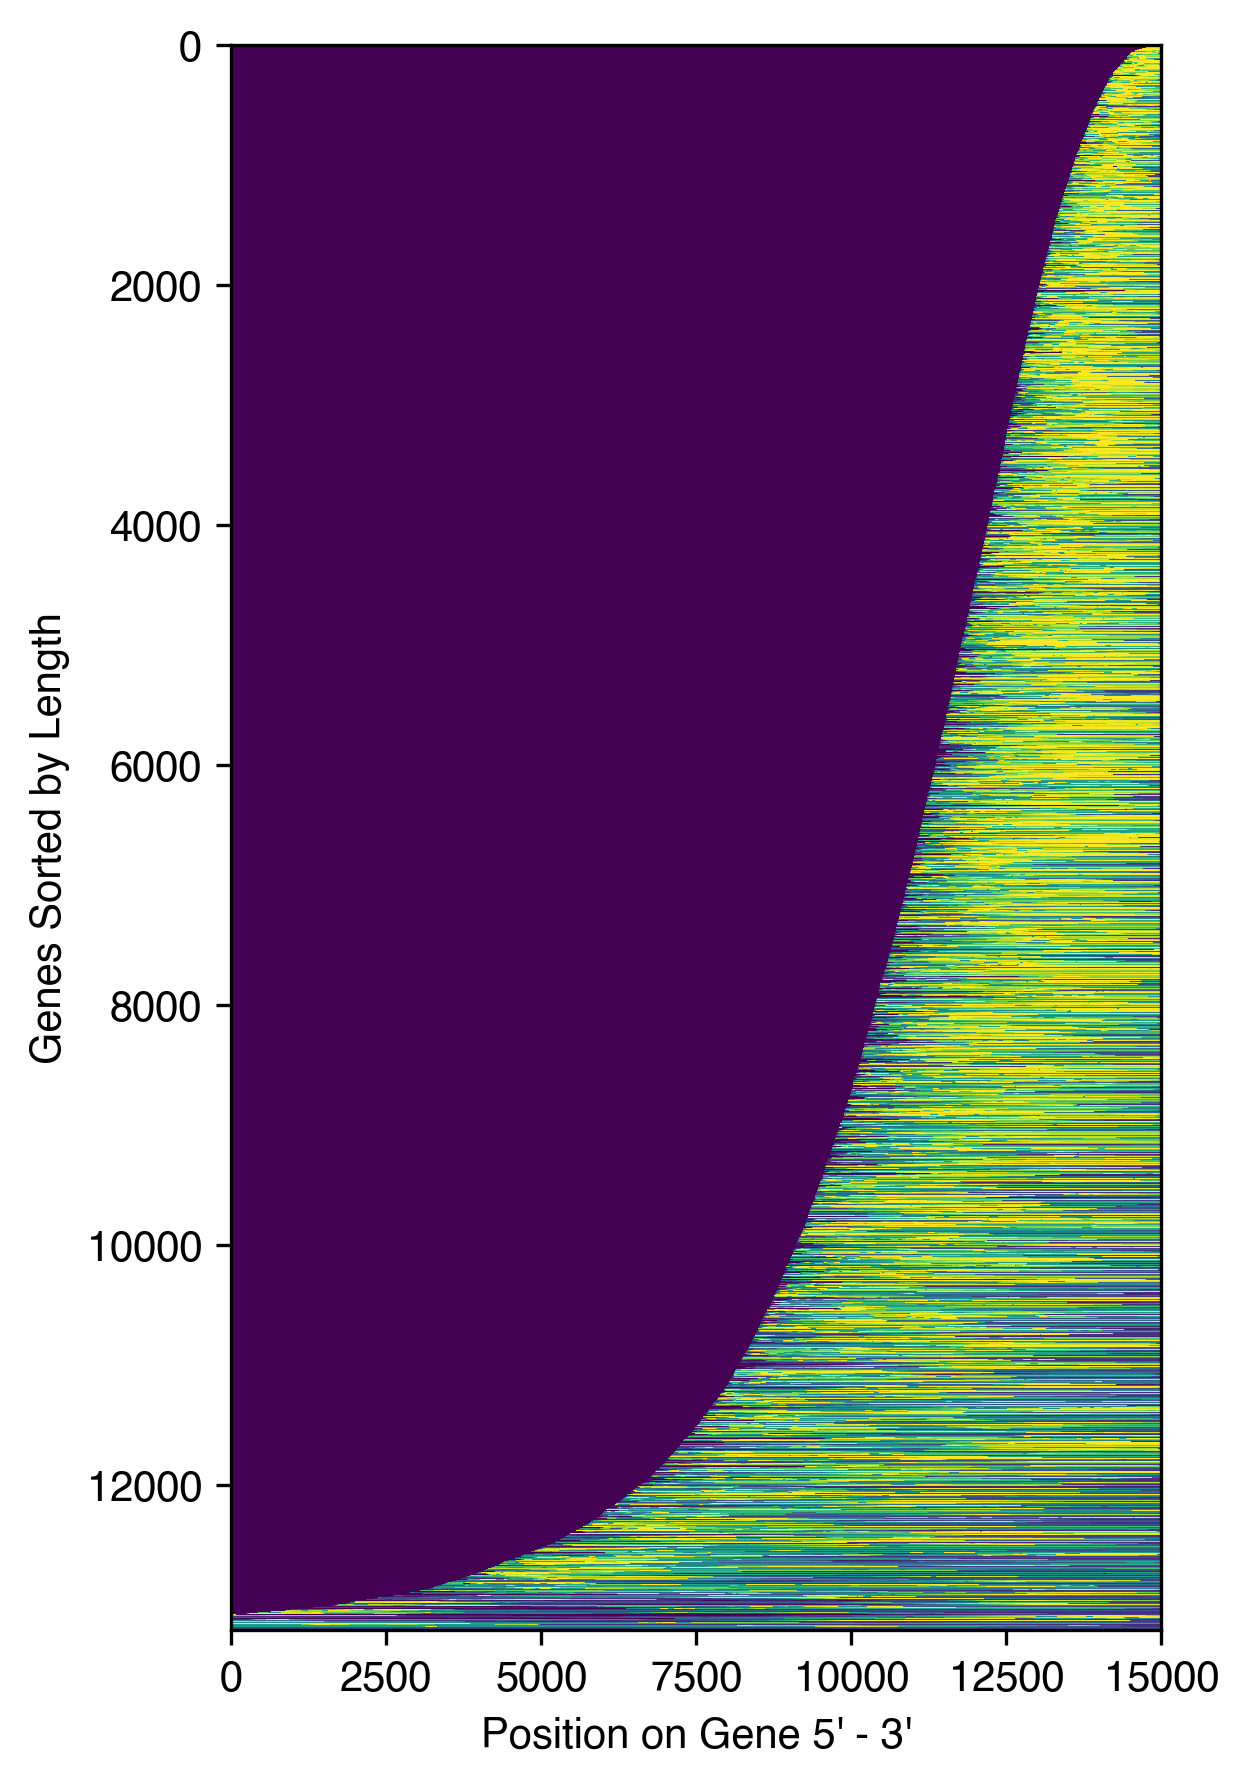

In [25]:
plt.rcParams['pdf.fonttype'] = 42 # use truetype so that whole font gets embedded and can be read by illustrator
plt.rcParams["font.family"] = "Helvetica" # match R plots
plt.figure(figsize=(4,7), dpi=300, facecolor=(1,1,1))
im = plt.imshow(hela_merge_gene_protCodingW5_absCov,
           vmin=0, vmax=1, 
           aspect='auto', #
           interpolation='none')
axes = plt.gca()
axes.set_xlim([0,15000])
plt.xlabel('Position on Gene 5\' - 3\'')
plt.ylabel('Genes Sorted by Length')

#cbar = plt.colorbar(im, orientation="horizontal")
#cbar.set_label("Relative coverage")
#plt.savefig('/Users/jops/lab/isoseq-plots/final/metacov_legend.pdf')

#plt.savefig('/Users/jops/lab/isoseq-plots/final/metacov.pdf')
plt.savefig('/Users/jops/Downloads/metacov.pdf')
#plt.show()

## Show only genes with length <= 5000

In [113]:
hela_merge_gene_protCodingW5_absCov=computeMetaDfAveragesNew(hela_merge_gene_protCodingMetaCoverageW5,
                                                             helaMergeMetaCleanW5TransLen, 5000)

num_genes 8274
max_len 5000


Text(0, 0.5, 'Genes Sorted by Length')

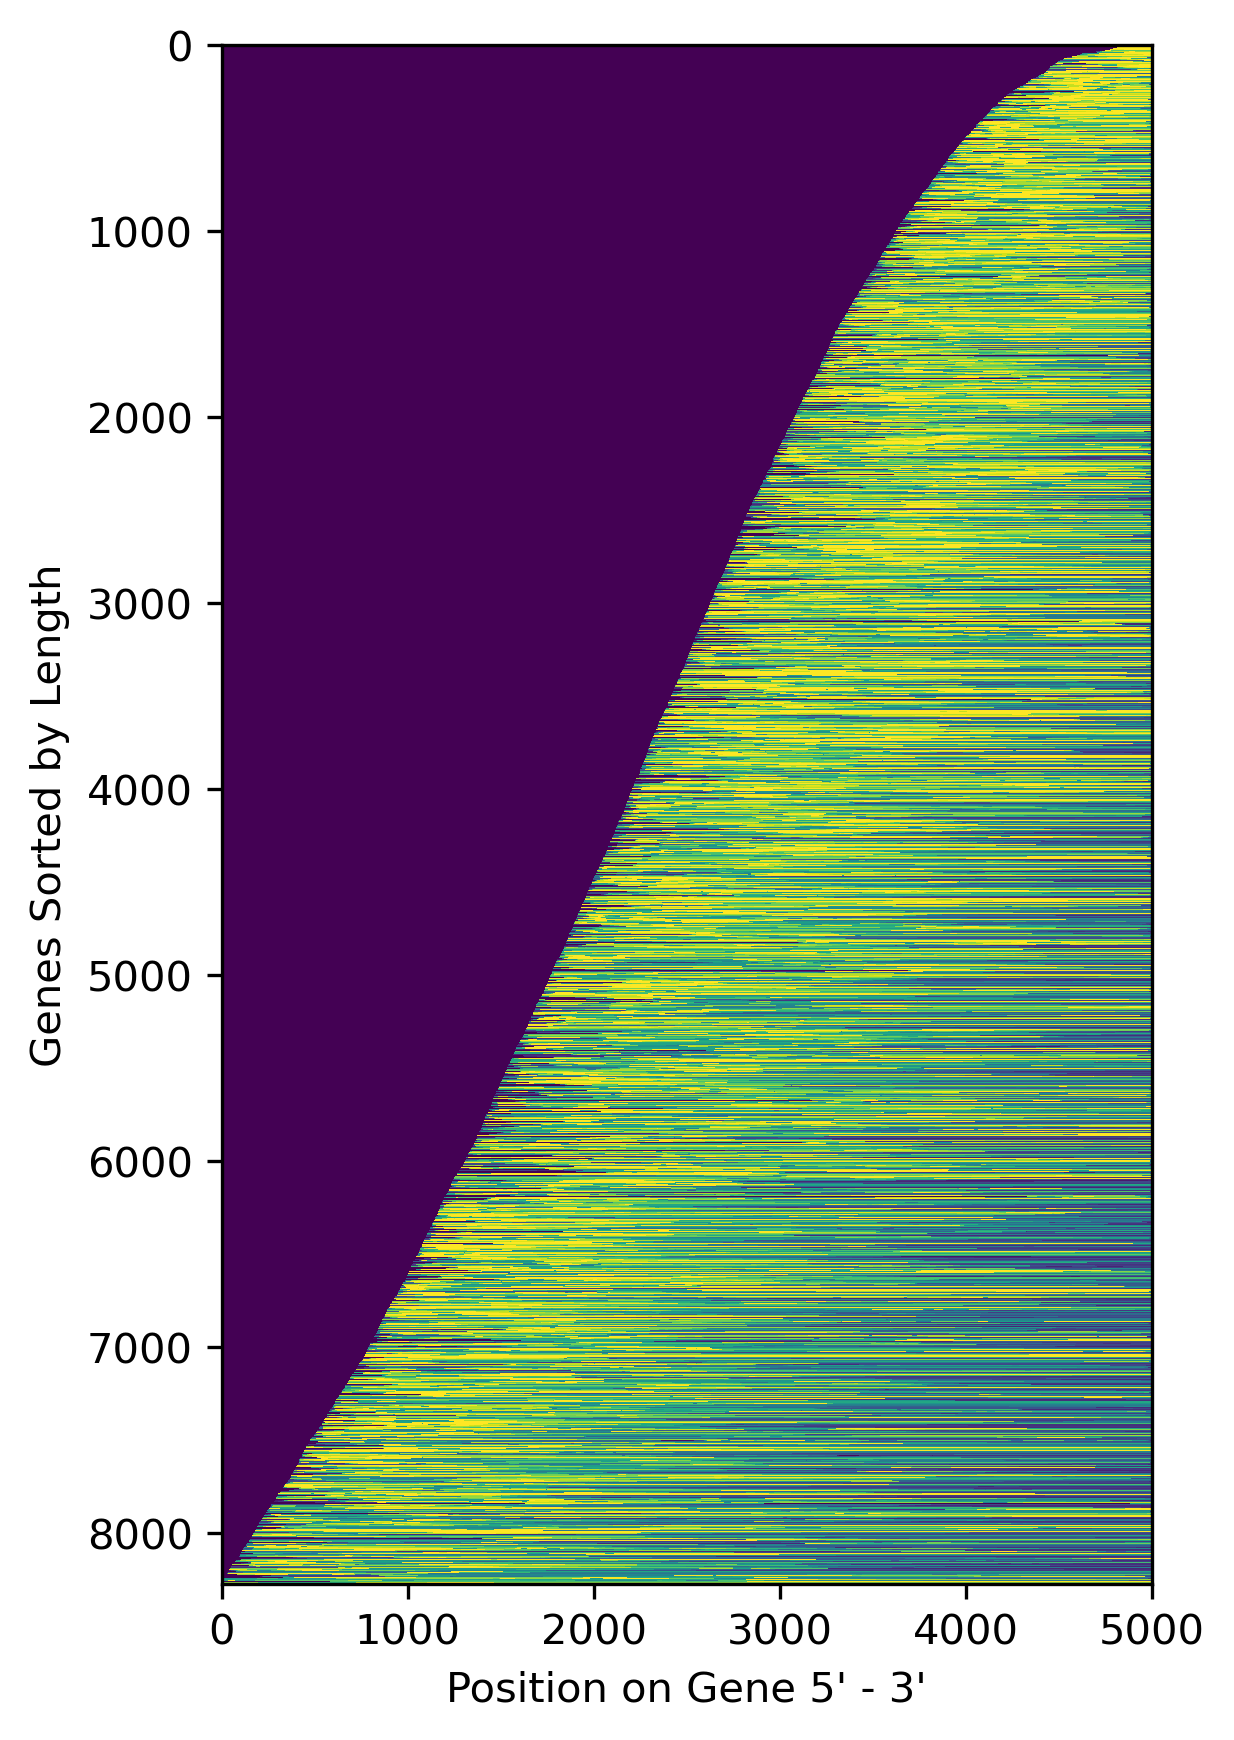

In [116]:
plt.figure(figsize=(4,7), dpi=300, facecolor=(1,1,1))
plt.imshow(hela_merge_gene_protCodingW5_absCov,
           vmin=0, vmax=1, 
           #aspect='auto',
           interpolation='none')
axes = plt.gca()
axes.set_xlim([0,5000])
plt.xlabel('Position on Gene 5\' - 3\'')
plt.ylabel('Genes Sorted by Length')

## Sort by expression

In [50]:
helaMergeMetaCleanW5TransLen

,gene,len
6992,AC022506.1,103
7005,CYP27B1,105
4647,AC083862.1,118
10226,CEACAM19,119
4072,AL035699.1,127
...,...,...
2305,ZBTB20,28469
3898,DST,31630
7806,FLRT2,33701
285,MACF1,34151


In [25]:
hela_merge_gene_protCodingMetaCoverageW5

{'NOC2L': array([21., 21., 21., ..., 17., 17., 13.]),
 'KLHL17': array([5., 5., 5., ..., 5., 5., 5.]),
 'HES4': array([ 6.,  6.,  6., ..., 21., 21., 17.]),
 'C1orf159': array([0., 0., 0., ..., 7., 7., 3.]),
 'SDF4': array([ 2.,  2.,  2., ..., 19., 19., 19.]),
 'UBE2J2': array([2., 2., 2., ..., 9., 9., 9.]),
 'ACAP3': array([ 8.,  8.,  8., ..., 11., 11., 11.]),
 'PUSL1': array([9., 9., 9., ..., 9., 9., 9.]),
 'INTS11': array([ 2.,  2.,  2., ..., 19., 19., 19.]),
 'CPTP': array([9., 9., 9., ..., 5., 5., 5.]),
 'MXRA8': array([ 0.,  0.,  0., ..., 11.,  5.,  3.]),
 'AURKAIP1': array([ 2.,  2.,  2., ..., 11., 11.,  9.]),
 'CCNL2': array([16., 16., 16., ..., 11., 11., 11.]),
 'MRPL20': array([ 4.,  4.,  4., ..., 11., 11., 11.]),
 'ATAD3B': array([13., 13., 13., ...,  2.,  2.,  2.]),
 'ATAD3A': array([7., 7., 7., ..., 7., 7., 7.]),
 'TMEM240': array([2., 2., 2., ..., 3., 3., 3.]),
 'SSU72': array([2., 2., 2., ..., 7., 7., 7.]),
 'MIB2': array([ 0.,  0.,  0., ..., 19., 19., 15.]),
 'CDK11B': a

In [34]:
len(helaMergeMetaCleanW5TransLen[helaMergeMetaCleanW5TransLen['len'] <= 5000])

8274

In [28]:
len(hela_merge_gene_protCodingMetaCoverageW5)

11649

In [69]:
helaMergeMetaCleanW5TransLen

,gene,len
6992,AC022506.1,103
7005,CYP27B1,105
4647,AC083862.1,118
10226,CEACAM19,119
4072,AL035699.1,127
...,...,...
2305,ZBTB20,28469
3898,DST,31630
7806,FLRT2,33701
285,MACF1,34151


In [70]:
genesSorted = helaMergeMetaCleanW5TransLen\
    .merge(
        gene_counts.rename('count'),
        left_on='gene',
        right_index=True,
        how='left')\
    .sort_values(
        by='count',
        ascending=False)\
    .drop('count', axis=1)
genesSorted

,gene,len
6883,TUBA1A,2882
11240,TMSB4X,1700
3920,EEF1A1,3427
11641,MT-CO1,1540
166,STMN1,2371
...,...,...
5273,AL358113.1,5023
3394,PCDHA6,5372
10551,AL035461.4,5860
11219,P2RY8,9054


In [99]:
hela_merge_gene_protCodingW5_absCov=computeMetaDfAverages(hela_merge_gene_protCodingMetaCoverageW5,
                                                             genesSorted, 15000)

Text(0, 0.5, 'Genes Sorted by Expression')

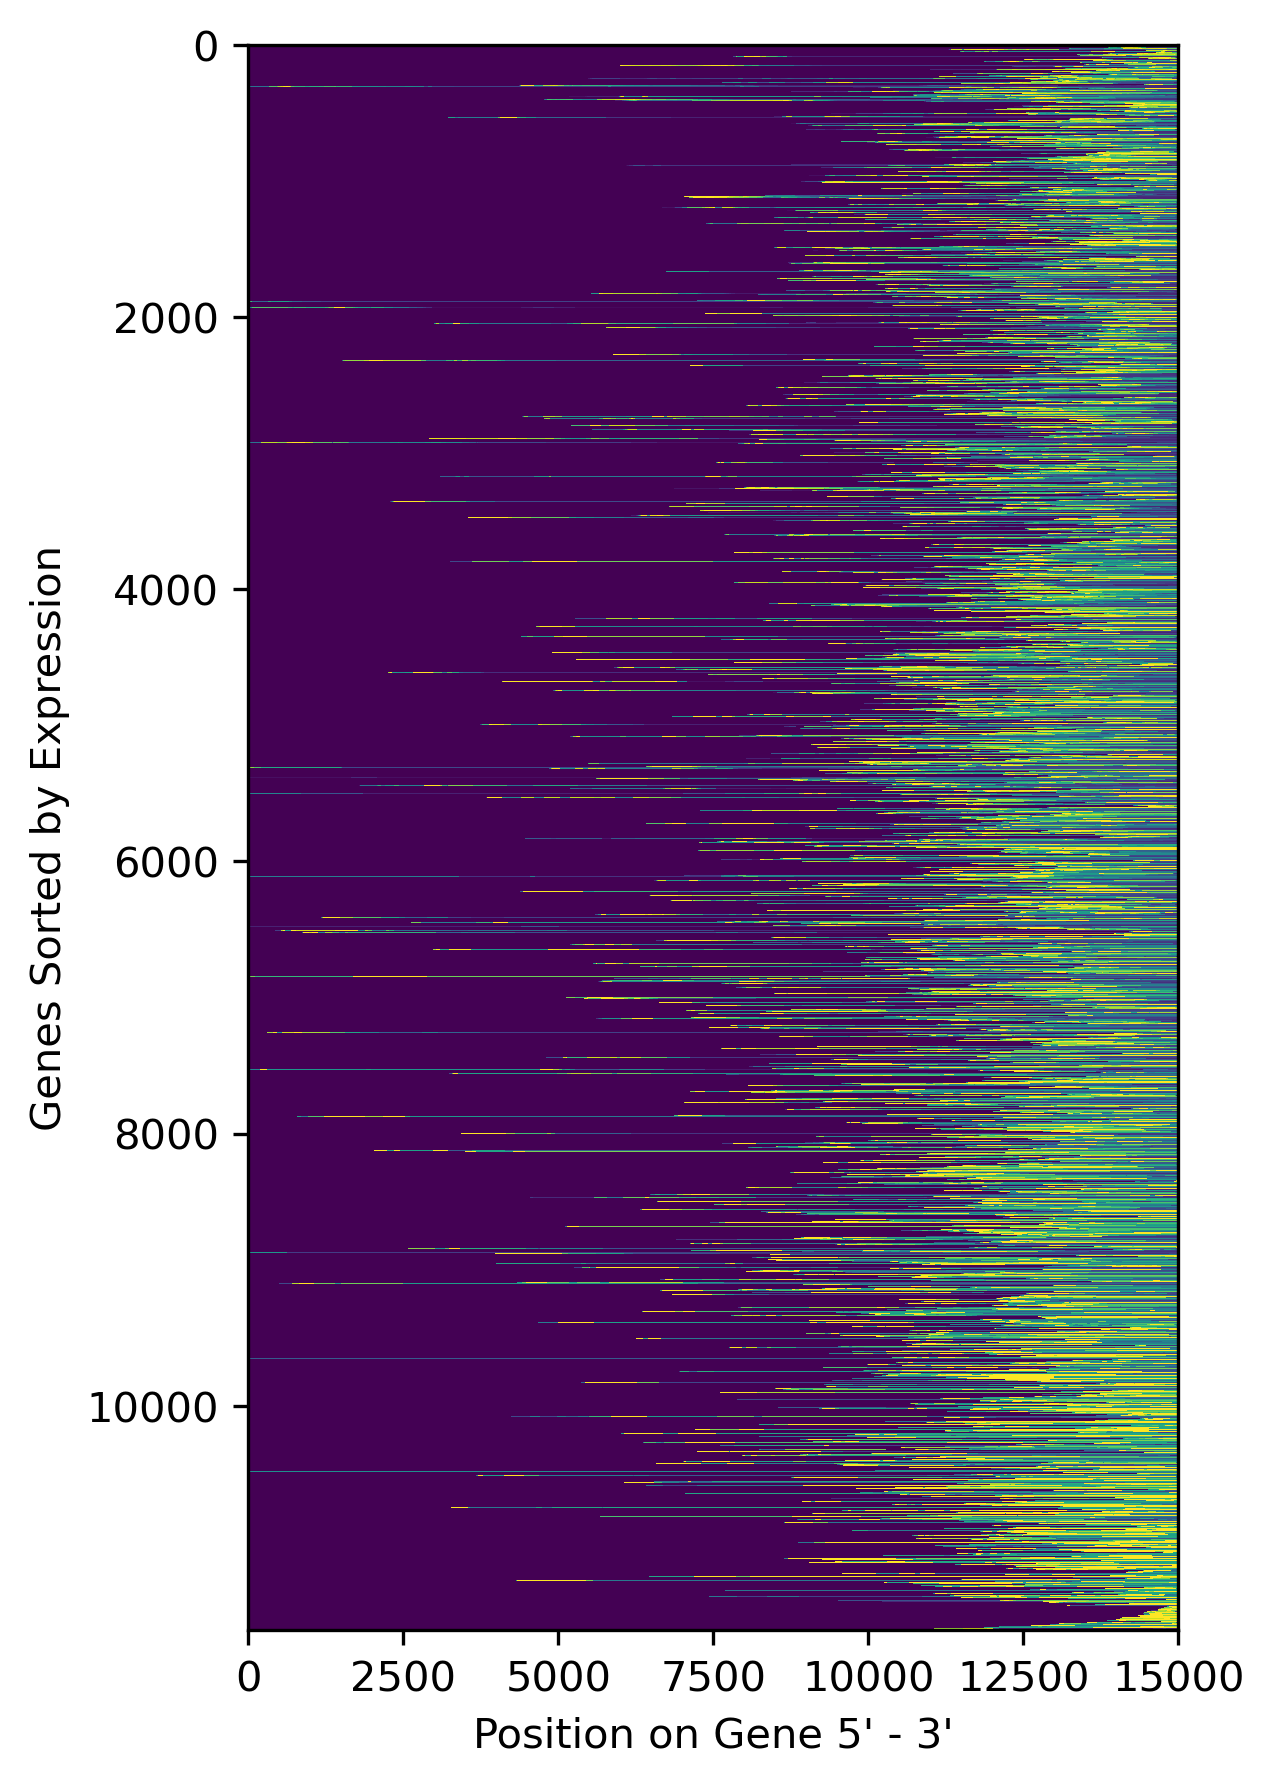

In [109]:
plt.figure(figsize=(4,7), dpi=300, facecolor=(1,1,1))
plt.imshow(hela_merge_gene_protCodingW5_absCov,
           vmin=0, vmax=1, 
           aspect='auto',
           interpolation='none')
axes = plt.gca()
axes.set_xlim([0,15000])
plt.xlabel('Position on Gene 5\' - 3\'')
plt.ylabel('Genes Sorted by Expression')
#plt.yticks([], [])

In [56]:
gene_counts_path = '../data/talon-freeze-0421/Gene_counts_7189_allSingleCells_4seurat.tsv.gz'
gene_counts = pd.read_csv(gene_counts_path, sep='\t', index_col='annot_gene_name').sum(axis=1)
gene_counts

annot_gene_name
AL669831.3           2
MTND1P23             6
MTND2P28           109
MTCO1P12            27
MTCO2P12             2
                  ... 
EXO1                22
TALONG000212691     26
TALONG000212818      3
KIF26B              49
AL627095.2           5
Length: 19367, dtype: int64

In [75]:
{k: len(v) for k,v in hela_merge_gene_protCodingMetaCoverageW5.items()}

{'NOC2L': 2755,
 'KLHL17': 2838,
 'HES4': 1038,
 'C1orf159': 3937,
 'SDF4': 2213,
 'UBE2J2': 3405,
 'ACAP3': 3791,
 'PUSL1': 1349,
 'INTS11': 3423,
 'CPTP': 2507,
 'MXRA8': 3086,
 'AURKAIP1': 1408,
 'CCNL2': 4141,
 'MRPL20': 1743,
 'ATAD3B': 4096,
 'ATAD3A': 2862,
 'TMEM240': 2007,
 'SSU72': 5207,
 'MIB2': 4124,
 'CDK11B': 3205,
 'SLC35E2B': 6396,
 'CDK11A': 3124,
 'SLC35E2A': 7292,
 'NADK': 4193,
 'GNB1': 3337,
 'TMEM52': 1393,
 'PRKCZ': 5310,
 'FAAP20': 2856,
 'MORN1': 6696,
 'RER1': 5045,
 'PEX10': 3111,
 'PANK4': 2654,
 'PRXL2B': 2846,
 'PRDM16': 8977,
 'TPRG1L': 2399,
 'WRAP73': 2090,
 'LRRC47': 4301,
 'CEP104': 7176,
 'DFFB': 3183,
 'C1orf174': 1643,
 'KCNAB2': 10637,
 'CHD5': 2732,
 'RPL22': 3042,
 'ICMT': 4793,
 'ACOT7': 3433,
 'TNFRSF25': 1697,
 'PLEKHG5': 6205,
 'NOL9': 6625,
 'ZBTB48': 2345,
 'PHF13': 3630,
 'THAP3': 1685,
 'DNAJC11': 3471,
 'CAMTA1': 7083,
 'VAMP3': 2668,
 'PER3': 911,
 'PARK7': 1192,
 'ERRFI1': 4006,
 'SLC45A1': 2784,
 'RERE': 11852,
 'ENO1': 2912,
 'SLC25

11649